<a href="https://colab.research.google.com/github/Dansah2/Udacity_Tutorials/blob/main/Udacity_ML_Forcasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

keras = tf.keras

In [ ]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

def trend(time, slope=0):
    return slope * time


def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))


def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)


def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

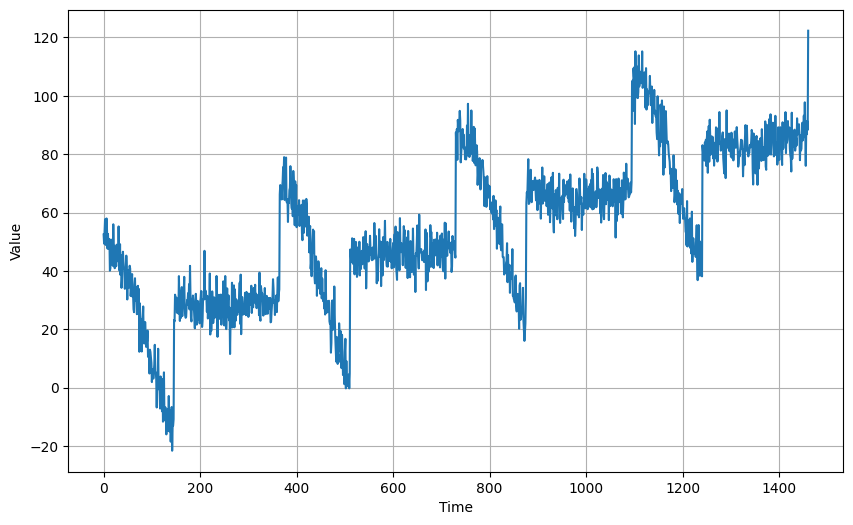

In [ ]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [ ]:
# use the previous method window_dataset that we created
def window_dataset(series, window_size, batch_size=32,
                   shuffle_buffer=1000):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [ ]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)

model = keras.models.Sequential([
    keras.layers.Dense(1, input_shape=[window_size])
])
optimizer = keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=['mae'])
model.fit(train_set, epochs=100, validation_data=valid_set)

Epoch 1/100
31/31 [==============================] - 1s 15ms/step - loss: 9.7088 - mae: 10.1951 - val_loss: 8.9889 - val_mae: 9.4737
Epoch 2/100
31/31 [==============================] - 0s 8ms/step - loss: 8.8912 - mae: 9.3815 - val_loss: 8.8970 - val_mae: 9.3862
Epoch 3/100
31/31 [==============================] - 0s 7ms/step - loss: 8.4329 - mae: 8.9185 - val_loss: 8.0759 - val_mae: 8.5632
Epoch 4/100
31/31 [==============================] - 0s 6ms/step - loss: 8.0905 - mae: 8.5780 - val_loss: 7.9680 - val_mae: 8.4555
Epoch 5/100
31/31 [==============================] - 0s 8ms/step - loss: 7.6899 - mae: 8.1741 - val_loss: 7.5244 - val_mae: 8.0100
Epoch 6/100
31/31 [==============================] - 0s 8ms/step - loss: 7.4497 - mae: 7.9336 - val_loss: 7.3302 - val_mae: 7.8186
Epoch 7/100
31/31 [==============================] - 0s 7ms/step - loss: 7.2957 - mae: 7.7842 - val_loss: 7.1962 - val_mae: 7.6785
Epoch 8/100
31/31 [==============================] - 0s 7ms/step - loss: 7.1502 -

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)

model = keras.models.Sequential([
    keras.layers.Dense(1, input_shape=[window_size])
])

lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-6 * 10**(epoch / 30)
)

optimizer = keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9)

model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=['mae'])

history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
31/31 [==============================] - 1s 3ms/step - loss: 15.6225 - mae: 16.1165 - lr: 1.0000e-06
Epoch 2/100
31/31 [==============================] - 0s 2ms/step - loss: 13.1410 - mae: 13.6321 - lr: 1.0798e-06
Epoch 3/100
31/31 [==============================] - 0s 2ms/step - loss: 12.8816 - mae: 13.3720 - lr: 1.1659e-06
Epoch 4/100
31/31 [==============================] - 0s 3ms/step - loss: 12.7830 - mae: 13.2739 - lr: 1.2589e-06
Epoch 5/100
31/31 [==============================] - 0s 2ms/step - loss: 12.6832 - mae: 13.1729 - lr: 1.3594e-06
Epoch 6/100
31/31 [==============================] - 0s 2ms/step - loss: 12.5586 - mae: 13.0488 - lr: 1.4678e-06
Epoch 7/100
31/31 [==============================] - 0s 2ms/step - loss: 12.4379 - mae: 12.9275 - lr: 1.5849e-06
Epoch 8/100
31/31 [==============================] - 0s 3ms/step - loss: 12.2958 - mae: 12.7848 - lr: 1.7113e-06
Epoch 9/100
31/31 [==============================] - 0s 4ms/step - loss: 12.1569 - mae: 12.6461 

(1e-06, 0.001, 0.0, 20.0)

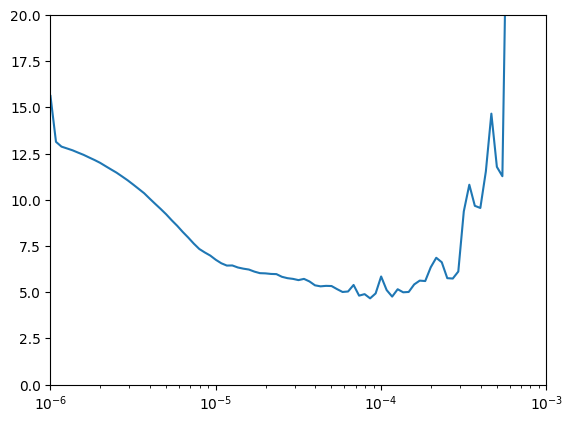

In [ ]:
plt.semilogx(history.history['lr'], history.history['loss'])
plt.axis([1e-6, 1e-3, 0, 20])

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)

model = keras.models.Sequential([
    keras.layers.Dense(1, input_shape=[window_size])
])
optimizer = keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=['mae'])
early_stopping = keras.callbacks.EarlyStopping(patience=10)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping])

Epoch 1/500
31/31 [==============================] - 2s 15ms/step - loss: 43.9836 - mae: 44.4811 - val_loss: 21.9277 - val_mae: 22.4253
Epoch 2/500
31/31 [==============================] - 0s 7ms/step - loss: 11.7223 - mae: 12.2124 - val_loss: 10.1541 - val_mae: 10.6394
Epoch 3/500
31/31 [==============================] - 0s 7ms/step - loss: 9.8036 - mae: 10.2918 - val_loss: 9.3781 - val_mae: 9.8684
Epoch 4/500
31/31 [==============================] - 0s 8ms/step - loss: 9.2745 - mae: 9.7620 - val_loss: 8.9774 - val_mae: 9.4670
Epoch 5/500
31/31 [==============================] - 0s 7ms/step - loss: 8.7363 - mae: 9.2196 - val_loss: 8.4075 - val_mae: 8.8947
Epoch 6/500
31/31 [==============================] - 0s 8ms/step - loss: 8.3097 - mae: 8.7959 - val_loss: 8.1219 - val_mae: 8.6052
Epoch 7/500
31/31 [==============================] - 0s 7ms/step - loss: 7.9933 - mae: 8.4785 - val_loss: 8.3720 - val_mae: 8.8536
Epoch 8/500
31/31 [==============================] - 0s 8ms/step - loss: 

In [ ]:
def model_forecast(model, series, window_size):
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size))
  ds = ds.batch(32).prefetch(1)
  forecast = model.predict(ds)
  return forecast

In [ ]:
lin_forecast = model_forecast(model,
                              series[split_time - window_size:-1],
                              window_size)[:, 0]

15/15 [==============================] - 0s 10ms/step


In [ ]:
lin_forecast.shape

(461,)

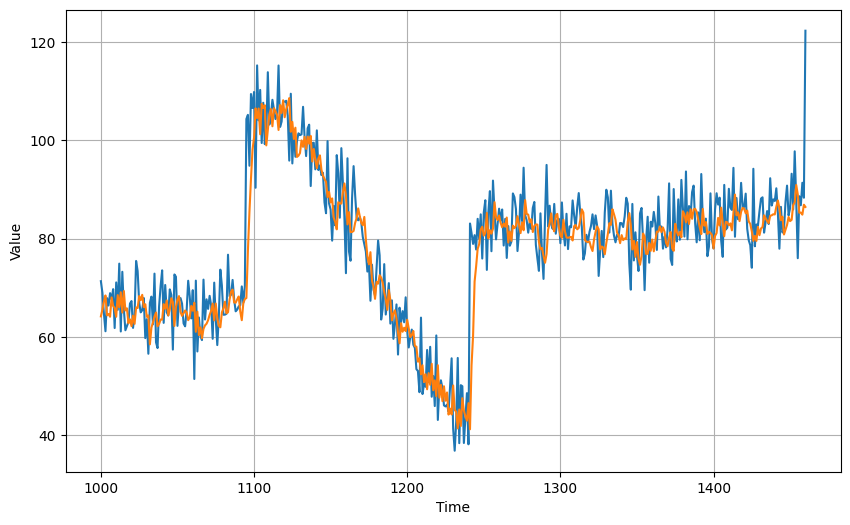

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, lin_forecast)

In [ ]:
keras.metrics.mean_absolute_error(x_valid, lin_forecast).numpy()

4.9601817

In [ ]:
# Dense Model Forecasting

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)

model = keras.models.Sequential([
    keras.layers.Dense(10, activation='relu', input_shape=[window_size]),
    keras.layers.Dense(10, activation='relu'),
    keras.layers.Dense(1)
])

lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7 * 10**(epoch / 20))

optimizer = keras.optimizers.SGD(learning_rate=1e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=['mae'])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


Epoch 1/100
31/31 [==============================] - 1s 3ms/step - loss: 49.9435 - mae: 50.4424 - lr: 1.0000e-07
Epoch 2/100
31/31 [==============================] - 0s 3ms/step - loss: 49.3481 - mae: 49.8470 - lr: 1.1220e-07
Epoch 3/100
31/31 [==============================] - 0s 2ms/step - loss: 48.6280 - mae: 49.1264 - lr: 1.2589e-07
Epoch 4/100
31/31 [==============================] - 0s 2ms/step - loss: 47.8333 - mae: 48.3320 - lr: 1.4125e-07
Epoch 5/100
31/31 [==============================] - 0s 2ms/step - loss: 46.9554 - mae: 47.4545 - lr: 1.5849e-07
Epoch 6/100
31/31 [==============================] - 0s 3ms/step - loss: 45.9829 - mae: 46.4817 - lr: 1.7783e-07
Epoch 7/100
31/31 [==============================] - 0s 2ms/step - loss: 44.9093 - mae: 45.4081 - lr: 1.9953e-07
Epoch 8/100
31/31 [==============================] - 0s 2ms/step - loss: 43.7208 - mae: 44.2197 - lr: 2.2387e-07
Epoch 9/100
31/31 [==============================] - 0s 3ms/step - loss: 42.4122 - mae: 42.9113 

(1e-07, 0.005, 0.0, 30.0)

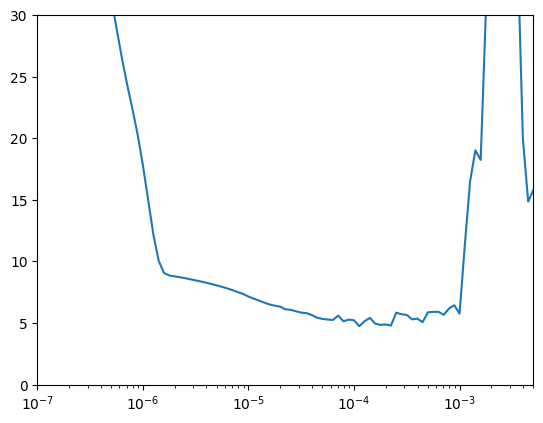

In [ ]:
plt.semilogx(history.history['lr'], history.history['loss'])
plt.axis([1e-7, 5e-3, 0, 30])

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(10, activation='relu', input_shape=[window_size]),
  keras.layers.Dense(10, activation='relu'),
  keras.layers.Dense(1)
])

optimizer = keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=['mae'])

early_stopping = keras.callbacks.EarlyStopping(patience=10)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping])

Epoch 1/500
31/31 [==============================] - 2s 23ms/step - loss: 44.0820 - mae: 44.5739 - val_loss: 7.3820 - val_mae: 7.8630
Epoch 2/500
31/31 [==============================] - 1s 10ms/step - loss: 8.8608 - mae: 9.3405 - val_loss: 8.5025 - val_mae: 8.9897
Epoch 3/500
31/31 [==============================] - 0s 8ms/step - loss: 8.6540 - mae: 9.1326 - val_loss: 7.1807 - val_mae: 7.6592
Epoch 4/500
31/31 [==============================] - 0s 8ms/step - loss: 8.5509 - mae: 9.0332 - val_loss: 7.7149 - val_mae: 8.1986
Epoch 5/500
31/31 [==============================] - 0s 6ms/step - loss: 8.4378 - mae: 8.9156 - val_loss: 7.0305 - val_mae: 7.5090
Epoch 6/500
31/31 [==============================] - 0s 7ms/step - loss: 8.3040 - mae: 8.7782 - val_loss: 7.4103 - val_mae: 7.8967
Epoch 7/500
31/31 [==============================] - 0s 7ms/step - loss: 8.2687 - mae: 8.7495 - val_loss: 6.8861 - val_mae: 7.3685
Epoch 8/500
31/31 [==============================] - 0s 6ms/step - loss: 8.1955

In [ ]:
dense_forecast = model_forecast(
    model,
    series[split_time - window_size:-1],
    window_size)[:, 0]

15/15 [==============================] - 0s 11ms/step


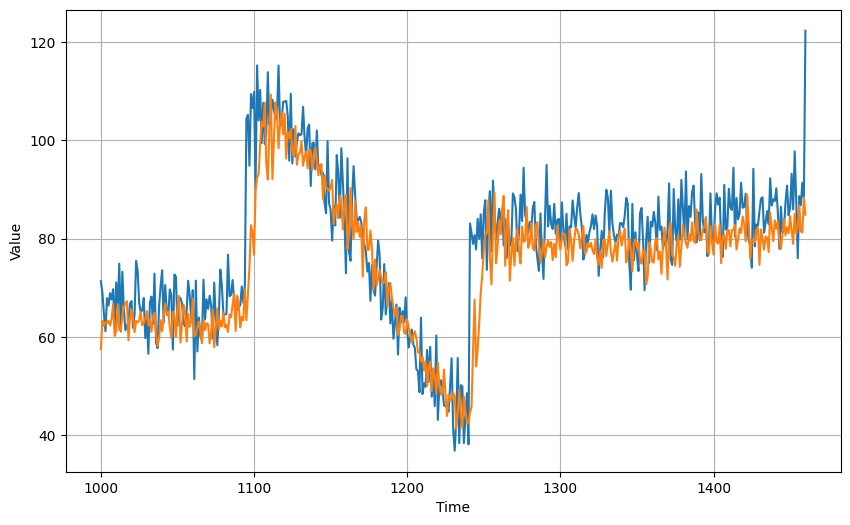

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, dense_forecast)

In [ ]:
keras.metrics.mean_absolute_error(x_valid, dense_forecast).numpy()